In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like
linear, quad, log = linear_like(), quad_like(), log_like()

In [47]:
def log_like_torch():
    def func(X, theta):
        return theta * torch.log(X)
    def inverse(y, theta):
        return torch.exp(y/theta)
    def prime(X, theta):
        return theta / X
    return likelihood(func, inverse, prime)
log_torch = log_like_torch()

In [42]:
def hessian_nd(logL, likelihood, mean, covinv, theta_max):
    logL = torch.from_numpy(logL)
    mean = torch.from_numpy(mean)
    covinv = torch.from_numpy(covinv)
    input = torch.tensor(theta_max, requires_grad=True)

    def logPr_bayes(logL, likelihood, mean, covinv, theta):
        """likelihood = f(X_i, theta)"""
        Xstar = likelihood.inverse(logL, theta)
        log_abs_fprimes = torch.log(abs(likelihood.prime(Xstar, theta)))
        return - torch.sum(log_abs_fprimes) - 1/2 * (Xstar - mean).T @ covinv @ (Xstar - mean)

    def logPr_bayes_max(theta):
        return logPr_bayes(logL, likelihood, mean, covinv, theta)
    
    from torch.autograd.functional import hessian
    H = hessian(logPr_bayes_max, input)
    return np.array(H)

In [54]:
def plot_laplace(thetas, logpr_max, theta_max, Hessian):
    logprs_laplace = np.zeros_like(thetas)
    logprs_bayes = np.zeros_like(thetas)
    for i, theta in enumerate(thetas):
        logprs_laplace[i] = logPr_laplace(theta, logpr_max, theta_max, Hessian)
        logprs_bayes[i] = logPr_bayes(np.array(y), log, mean_X, covinv_X, theta)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(thetas, logprs_laplace)
    ax1.plot(thetas, logprs_bayes)
    ax2.plot(thetas, np.exp(logprs_laplace - logprs_laplace.max()), lw=.5)
    ax2.plot(thetas, np.exp(logprs_bayes - logprs_bayes.max()), lw=.5)

In [43]:
nk = 500 * np.ones(500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

In [103]:
X_true = generate_Xs(nk)
theta_true = 10
y = log_torch.func(torch.tensor(X_true), theta_true)
theta_b = minimise_bayes(np.array(y), log, mean_X, covinv_X, theta_true).x
theta_l = minimise_ls(np.array(y), log, mean_X, theta_true).x
H = hessian_nd(np.array(y), log_torch, mean_X, covinv_X, theta_b)
cov_theta = np.linalg.inv(-H)

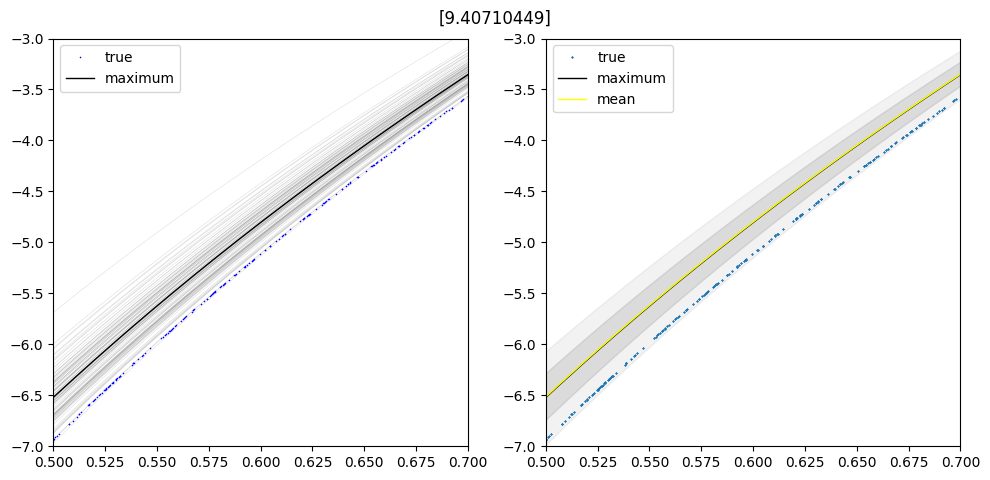

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
xlim = (0.5, 0.7)
ylim = (-7, -3)
for i in range(100):
    theta = np.random.multivariate_normal(theta_b, cov_theta)
    X_b = log.inverse(y, theta)
    ax1.plot(X_b, y, lw=.1, color='gray')
ax1.plot(X_true, y, 'x', ms=.5, color='blue', label='true')
ax1.plot(log.inverse(y, theta_b), y, lw=1, color='black', label='maximum')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.legend();

samples = 1000
Xarrays = np.zeros((samples, len(y)))
for i in range(samples):
    theta = np.random.multivariate_normal(theta_b, cov_theta)
    X_b = log.inverse(y, theta)
    Xarrays[i] = X_b
X_std = Xarrays.T.std(axis=1)
X_mean = Xarrays.T.mean(axis=1)

X_b = log.inverse(y, theta_b)
X_l = log.inverse(y, theta_l)
ax2.plot(X_true, y, 'x', ms=1, label='true')
ax2.plot(X_b, y, lw=1, color='black', label='maximum')
ax2.plot(X_mean, y, lw=1, color='yellow', label='mean')
ax2.fill_betweenx(y, X_mean - 2*X_std, X_mean + 2*X_std, color='gray', alpha=0.1)
ax2.fill_betweenx(y, X_mean - X_std, X_mean + X_std, color='gray', alpha=0.2)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.legend();
plt.suptitle(theta_b, y=.95)
plt.tight_layout()

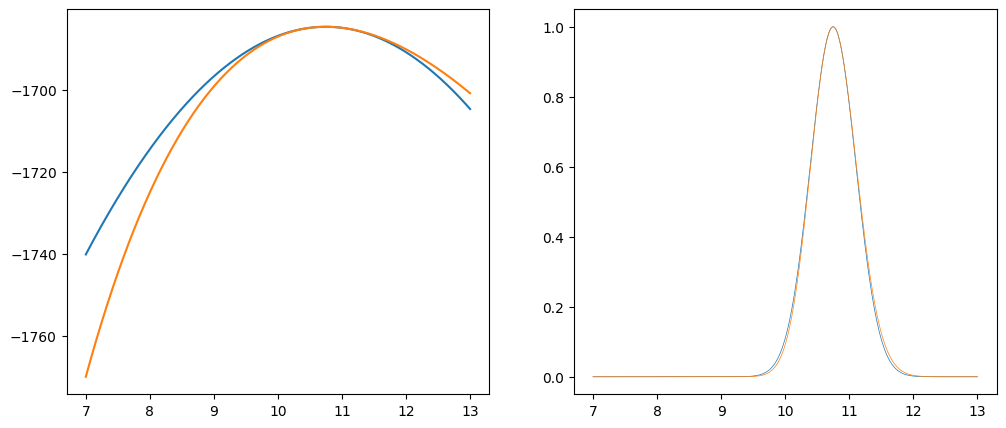

In [55]:
ds = np.linspace(7, 13, 500)
plot_laplace(ds, logPr_bayes(np.array(y), log, mean_X, covinv_X, theta_b), theta_b, H)